# Value Iteration for the Gambler's Problem

Exercise 4.8

### In this notebook, we cover the implementation of value iteration for the gambler's problem

This environment is episodic, and stochastic. The state is the amount of money the gambler has, and the available actions are to bet a certain amount of money. With some fixed percentage, the gambler will win and receive the amount of money bet, and otherwise loses the amount of money bet. The gambler's capital is between 1 and 99 dollars. The episode wins when the gambler has 0 or 100 dollars. Reward is zero on all transitions except those in which the gambler reaches \$100. Since this is episodic, we use no discount $\gamma$, so you won't see it in the code.

In [231]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
np.set_printoptions(precision=17, suppress=True)

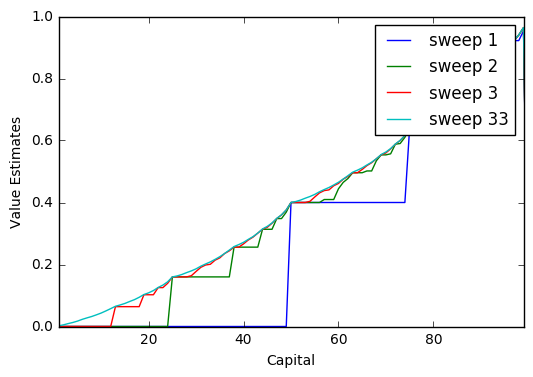

In [232]:
converged = False
p = 0.4
V = np.zeros(101)
iters = 0
Vs = []

while not converged:
    # sweep over states and update the value function
    delta = 0
    for s in range(1, 100):
        # update the value of state s
        max_bet = min(s, 100 - s)
        Q = np.zeros(max_bet)
        for a in range(1, max_bet + 1):
            # reward of winning and losing weighted by p and (1 - p)
            # the addition of these two conditions represents the sum of s' in Eq 4.10
            win_capital = s + a
            lose_capital = s - a
            lose_reward = 0 # works cuz episode ends when this happens so reward is limited
            win_reward = 1 if win_capital == 100 else 0
            q = p * (win_reward + V[win_capital]) + (1 - p) * (lose_reward + V[lose_capital])
            Q[a - 1] = q
        v = V[s]
        V[s] = np.max(Q)
        delta = max(delta, abs(V[s] - v))
        
    Vs.append(V.copy())
    iters += 1
    
    if delta == 0.0:
        converged = True
        
# Show graphs of value estimates
plt.xlabel("Capital")
plt.ylabel("Value Estimates")
axes = plt.gca()
axes.set_xlim([1, 99])
axes.set_ylim([0, 1])

plt.plot(Vs[0], label="sweep 1")
plt.plot(Vs[1], label="sweep 2")
plt.plot(Vs[2], label="sweep 3")
plt.plot(Vs[iters - 1], label="sweep {}".format(iters))
plt.legend()
    
plt.show()

### Now the Final Policy

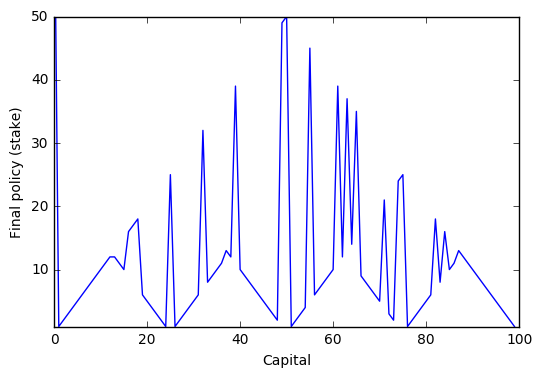

In [233]:
pi = np.ndarray(100)
Qs = [0]

for s in range(1, 100):
    max_bet = min(s, 100 - s)
    Q = np.zeros(max_bet + 1)
    for a in range(1, max_bet + 1):
        # reward of winning and losing weighted by p and (1 - p)
        # the addition of these two conditions represents the sum of s' in Eq 4.10
        win_capital = s + a
        lose_capital = s - a
        lose_reward = 0 # works cuz episode ends when this happens so reward is limited
        win_reward = 1 if win_capital == 100 else 0
        q = p * (win_reward + V[win_capital]) + (1 - p) * (lose_reward + V[lose_capital])
        Q[a] = q

    best_a = np.argmax(Q)
    pi[s] = best_a
    Qs.append(Q)
    
plt.plot(pi)
axes = plt.gca()
axes.set_xlim([0, 100])
axes.set_ylim([1, 50])
plt.xlabel("Capital")
plt.ylabel("Final policy (stake)")
plt.show()

### Answering the exercise questions

Notice how the graph doesn't exactly match the graph in the book? Well if you look carefully, it seems to be a numerical stability issue. Specifically, there are often two actions that miximize expected reward for each state. One is the maximum possible bet. I don't know why, so lets try to find out... recall $\gamma$ here is 1.0 so we ignore it.

$$ V(s) \leftarrow \max_a \sum_{s'} P^a_{ss'} * [R^a_{ss'} + V(s)]$$
$$ V(s) \leftarrow \max_a (p * [R^a_{s,s+a} + V(s + a)] + (1 - p) * [0 + V(s - a)])$$
consider when episode ends versus all other wins
$$ V(s) \leftarrow
\begin{cases}
   \max_a (p * [1 + V(s + a)] + (1 - p) * [0 + V(s - a)])& a + s = 100 \\
   \max_a (p * [0 + V(s + a)] + (1 - p) * [0 + V(s - a)])& a + s < 100 \\
\end{cases}
$$
drop some zeros
$$ V(s) \leftarrow
\begin{cases}
   \max_a (p * [1 + V(s + a)] + (1 - p) * V(s - a))& a + s = 100 \\
   \max_a (p * V(s + a) + (1 - p) * V(s - a))& a + s < 100 \\
\end{cases}
$$

If we have capital of < 50, then we cannot win, and we can ignore one of the conditions. In this event:

$$V(s) \leftarrow \max_a (p * V(s + a) + (1 - p) * V(s - a))$$

We can check our code and see if this is true:

In [234]:
s = 16
Q16 = Qs[s]
best_a = np.argmax(Q16)
v1 = V[s]
v2 = p * V[s + best_a] + (1 - p)*V[s - best_a]
print(v1, v2, best_a)

0.0806884678338 0.0806884678338 16


Notice that there are two values with maximal expected value. for $s = 16$, they are 9 and 16. 16 of course corresponds to betting all your money. Let's look at that in the general case of $s < 50$ and $a == s$

$$Q(s, a) = p * V(s + a) + (1 - p) * V(s - a)$$
$$Q(s, a) = p * V(s + s) + (1 - p) * V(s - s)$$
$$Q(s, a) = p * V(s + s) + (1 - p) * V(0)$$
$$Q(s, a) = p * V(s + s) + (1 - p) * 0)$$
$$Q(s, a) = p * V(s + s)$$

Can I prove why 9 and 16 should have the same V? What about 8 and 17?

In [235]:
# first element of each Q is just padding. You can't bet 0.
Qs[16][1:]

array([ 0.07930316110416472,  0.07940624237977226,  0.08040107488737835,
        0.07805901395753781,  0.07659933247094884,  0.07643256845267987,
        0.07604303396673953,  0.07702442645381478,  0.08068846783376234,
        0.07907758146761745,  0.07752967655361107,  0.07728137555271754,
        0.07728137555271752,  0.07752967655361107,  0.07907758146761745,
        0.08068846783376235])

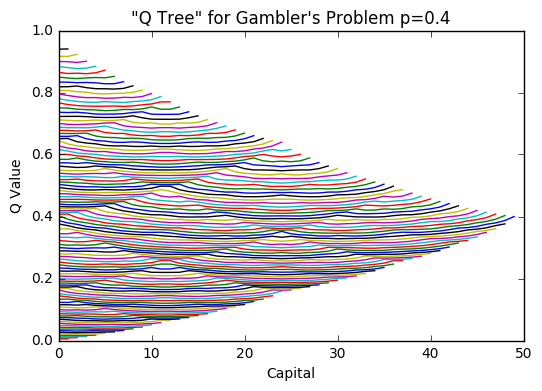

In [236]:
for s, Q in enumerate(Qs[1:]):
    Q = Q[1:]
    plt.plot(Q, label="capital {}".format(s + 1))

plt.xlabel("Capital")
plt.ylabel("Q Value")
plt.title("\"Q Tree\" for Gambler's Problem p=0.4")
plt.show()

** WOAH, that was unexpected. What a pretty graph! Let's see if I can explain what it means**

## Let's call it a Q Tree!

This is a visualization of the action values for the Gambler's problem, with p=0.4. Each colored line represents one state, and in this case there are 99 of them {1 - 99}. The Y axis is the Q value. In this environment, we can also think about it as the probability of winning, since the reward for winning is 1, and the reward for everything else is zero. At 99, the action value for your only available action, betting \$1, is 0.96433. We can derive this from the formula:

$$ Q(99, 1) = P^{1}_{99, 100} [ R_{win} + V(100)] + P^{1}_{99, 98} [ R_{lose} + V(98)] $$
$$ Q(99, 1) =  0.4 * [ 1 + V(100)] + 0.6 * [ 0 + V(98)] $$

In [237]:
print(V[98], V[99], V[100])

0.940554945379 0.964332967227 0.0


$$ Q(99, 1) = 0.4 * [ 1 + V(100)] + 0.6 * [ 0 + V(98)] $$
$$ Q(99, 1) = 0.4 * [ 1 + 0] + 0.6 * [ 0 + 0.94055] $$
$$ Q(99, 1) = 0.4 + 0.6 * 0.94055$$
$$ Q(99, 1) = 0.96433$$


Hmmm what is V[100] was set to 1?
$$ Q(99, 1) = 0.4 * [ 1 + 1] + 0.6 * [ 0 + 0.94055] $$
$$ Q(99, 1) = 0.4 * 2 + 0.6 * 0.94055$$
$$ Q(99, 1) = 1.3643$$

I guess it doesn't matter? anyways back to explaining that graph...

So as you get closer to \$100, you get closer to that _sweet sweet_ reward of 1, so the action values get higher. The swoopyness still kind of confuses me. The fact that it is triangular, with the middle being the longest, is because at 50 you have the most possible actions/capital to bet.